# Custom_CNN1
Model changes

In [1]:
import os
import fnmatch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from natsort import natsorted

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten,Dropout, BatchNormalization, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import regularizers
from tensorflow_addons.metrics import RSquare
from imgaug import augmenters as img_aug

import warnings
import random
import cv2
import pickle
warnings.filterwarnings('ignore')

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)]) # Notice here
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

In [3]:
# Load csv file 
df = pd.read_csv('../datasets/PiCar/training_norm.csv', index_col=False)
df.head()

,image_id,angle,speed
0,1,0.4375,0.0
1,2,0.8125,1.0
2,3,0.4375,1.0
3,4,0.6250,1.0
4,5,0.5000,0.0


In [4]:
df.shape

(13793, 3)

In [47]:
#df = df.drop('image_id', axis=1)
#df.head()

In [5]:
df['angle'].value_counts()

0.7500    2123
0.5000    2046
0.6875    2007
0.6250    1963
0.5625    1609
0.4375    1467
0.8125    1147
0.3750     428
0.8750     301
0.3125     213
0.2500     104
0.1250      99
0.1875      98
0.9375      65
0.0000      60
1.0000      35
0.0625      28
Name: angle, dtype: int64

In [6]:
a = df['image_id'].tolist()
b = [x for x in range(a[0], a[-1] + 1)]
missing_vals = list(set(a) ^ set(b))
print('Missing data:', missing_vals)

Missing data: [3141, 3999, 4895, 8285, 10171]


In [7]:
images_dir = '../datasets/PiCar/train/training_data'
file_list = os.listdir(images_dir)
image_paths = []
pattern = "*.png"

for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(images_dir,filename))

image_paths = natsorted(image_paths)
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/3141.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/3999.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/4895.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/8285.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data/10171.png']

image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data\\3141.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data\\3999.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data\\4895.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data\\8285.png']
image_paths = [string for string in image_paths if string != '../datasets/PiCar/train/training_data\\10171.png']

images = pd.DataFrame (image_paths, columns = ['images'])
images.describe()

,images
count,13793
unique,13793
top,../datasets/PiCar/train/training_data/6963.png
freq,1


In [8]:
df_all = pd.concat([df, images], axis=1)
df_all = df_all.drop('image_id', axis=1)
df_all.tail()

,angle,speed,images
13788,0.6250,1.0,../datasets/PiCar/train/training_data/13794.png
13789,0.4375,1.0,../datasets/PiCar/train/training_data/13795.png
13790,0.5625,0.0,../datasets/PiCar/train/training_data/13796.png
13791,0.6250,0.0,../datasets/PiCar/train/training_data/13797.png
13792,0.6875,1.0,../datasets/PiCar/train/training_data/13798.png


In [9]:
df_all.shape

(13793, 3)

In [11]:
#le = LabelEncoder()
#df_all['angle']= le.fit_transform(df_all['angle'])
#df_all.head()

image_path: ../datasets/PiCar/train/training_data/11.png
steering_Angle: 0.6875
Speed: 0.0


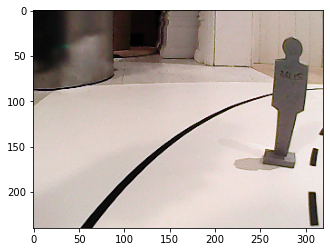

In [10]:
image_paths = df_all['images'].tolist()
steering_angles = df_all['angle'].tolist()
speed = df_all['speed'].tolist()


image_index = 10
plt.imshow(Image.open(image_paths[image_index]))
print("image_path: %s" % image_paths[image_index]) 
print("steering_Angle:", steering_angles[image_index]) 
print("Speed:", speed[image_index]) 


(240, 320, 3)


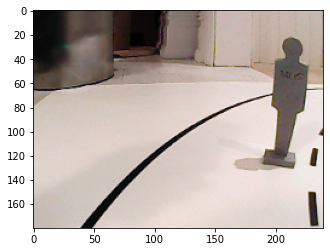

In [11]:
test_image = cv2.imread(df_all['images'][10])
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
print(test_image.shape)
test_image = cv2.resize(test_image, (240,180))
plt.imshow(test_image)
plt.show()

In [12]:
X_train, X_valid = train_test_split( df_all, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

Training data: 11034
Validation data: 2759


In [35]:
class Custom_CNN1(tf.keras.Model):
  def __init__(self):
    super().__init__()
    
    self.conv1 = Conv2D(24, 5,strides=(2, 2), activation='relu')
    self.conv2 = Conv2D(36, 5, strides=(2, 2),activation='relu')
    self.conv3 = Conv2D(48, 5, strides=(2, 2),activation='relu')
    self.conv4 = Conv2D(64, 3, strides=(2, 2),activation='relu')
    #self.drop1 = Dropout(0.25)
    self.batch1 = BatchNormalization()
    self.conv5 = Conv2D(64, 3,strides=(2, 2),activation='relu')
    
    self.flatten = Flatten()
    self.drop2 = Dropout(0.25)
    self.d1 = Dense(128, activation='relu')
    self.d2 = Dense(64, activation='relu')
    self.d3 = Dense(32, activation='relu')
    #self.d4 = Dense(16, activation='relu')
    
    self.Y1 = Dense(1, activation='relu')    
    self.Y2 = Dense(1, activation = 'sigmoid')

  def call(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    #x = self.drop1(x)
    x = self.batch1(x)
    x = self.conv5(x)
    
    x = self.flatten(x)
    x = self.drop2(x)
    x = self.d1(x)
    x = self.d2(x)
    x = self.d3(x)
    #x = self.d4(x)
    
    
    y1 = self.Y1(x)
    y2 = self.Y2(x)
    
    return y1,y2

In [14]:
model = Custom_CNN1()
model.build((1,240, 180, 3))
model.summary()

Model: "custom_cnn1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  1824      
                                                                 
 conv2d_1 (Conv2D)           multiple                  21636     
                                                                 
 conv2d_2 (Conv2D)           multiple                  43248     
                                                                 
 conv2d_3 (Conv2D)           multiple                  27712     
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 conv2d_4 (Conv2D)           multiple                  36928     
                                                       

In [15]:
def zoom(image):
    zoom = img_aug.Affine(scale=(1, 1.2))  # zoom from 100% (no zoom) to 120%
    image = zoom.augment_image(image)
    return image

def pan(image):
    # pan left / right / up / down about 10%
    pan = img_aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

def adjust_brightness(image):
    # increase or decrease brightness by 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image

def blur(image):
    kernel_size = random.randint(1, 3)  # kernel larger than 5 would make the image way too blurry
    image = cv2.blur(image,(kernel_size, kernel_size))
    return image

def random_augment(image):
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = blur(image)
    if np.random.rand() < 0.5:
        image = adjust_brightness(image)
    return image

In [16]:
def random_flip(image):
    is_flip = random.randint(0, 1)
    if is_flip == 1:
        image = cv2.flip(image,1)
    return image, is_flip

In [17]:
def custom_generator(df, batch_size, target_size, is_training):
    while True:
        # Shuffle the data
        df = df.sample(frac=1).reset_index(drop=True)
        for i in range(0, len(df), batch_size):
            batch = df[i:i+batch_size]
            # Load images and labels
            images = []
            angles = []
            speeds = []
            for _, row in batch.iterrows():
                img = cv2.imread(row['images'])
                angle = row['angle']
                speed = row['speed']

                if is_training:
                    img = random_augment(img)
                    img, is_flip = random_flip(img)
                    if is_flip:
                        angle = 1 - angle

                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, target_size)

                images.append(img)
                angles.append(angle)
                speeds.append(speed)

            # Normalize images
            images = np.array(images) / 255.0
            # Convert labels to arrays
            angles = np.array(angles)
            speeds = np.array(speeds)
            yield images, {'output_1': angles, 'output_2': speeds}

In [18]:
tf.keras.backend.clear_session()

# Early stop added
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

train_gen = custom_generator(X_train, batch_size=32 ,target_size=(240, 180), is_training= True)
val_gen = custom_generator(X_valid, batch_size=32, target_size=(240, 180), is_training= False)

model = Custom_CNN1()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                       loss={
        "output_1" : tf.keras.losses.MeanSquaredError(),
        "output_2" : tf.keras.losses.BinaryCrossentropy(from_logits=False)},
        metrics={"output_1": 'mse', "output_2": 'accuracy'})


history = model.fit(train_gen,
                    steps_per_epoch=len(X_train) // 32,
                    validation_data=val_gen,
                    validation_steps=len(X_valid) // 32,
                    callbacks=[callback],
                    epochs=80)

model.save('model/Custom_CNN1',save_format='tf')

history_path = os.path.join('history.pickle')
with open(history_path, 'wb') as f:
    pickle.dump(history.history, f, pickle.HIGHEST_PROTOCOL)

Epoch 1/80
344/344 [==============================] - 66s 187ms/step - loss: 0.5223 - output_1_loss: 0.0487 - output_2_loss: 0.4736 - output_1_mse: 0.0487 - output_2_accuracy: 0.7854 - val_loss: 1.4110 - val_output_1_loss: 0.1935 - val_output_2_loss: 1.2175 - val_output_1_mse: 0.1935 - val_output_2_accuracy: 0.2674
Epoch 2/80
344/344 [==============================] - 64s 188ms/step - loss: 0.2779 - output_1_loss: 0.0341 - output_2_loss: 0.2438 - output_1_mse: 0.0341 - output_2_accuracy: 0.9106 - val_loss: 0.2141 - val_output_1_loss: 0.0356 - val_output_2_loss: 0.1785 - val_output_1_mse: 0.0356 - val_output_2_accuracy: 0.9324
Epoch 3/80
344/344 [==============================] - 65s 188ms/step - loss: 0.2226 - output_1_loss: 0.0274 - output_2_loss: 0.1952 - output_1_mse: 0.0274 - output_2_accuracy: 0.9269 - val_loss: 0.1655 - val_output_1_loss: 0.0235 - val_output_2_loss: 0.1420 - val_output_1_mse: 0.0235 - val_output_2_accuracy: 0.9415
Epoch 4/80
344/344 [=============================

Epoch 27/80
344/344 [==============================] - 65s 189ms/step - loss: 0.0879 - output_1_loss: 0.0126 - output_2_loss: 0.0753 - output_1_mse: 0.0126 - output_2_accuracy: 0.9706 - val_loss: 0.0960 - val_output_1_loss: 0.0191 - val_output_2_loss: 0.0769 - val_output_1_mse: 0.0191 - val_output_2_accuracy: 0.9695
Epoch 28/80
344/344 [==============================] - 65s 189ms/step - loss: 0.0876 - output_1_loss: 0.0127 - output_2_loss: 0.0749 - output_1_mse: 0.0127 - output_2_accuracy: 0.9703 - val_loss: 0.1131 - val_output_1_loss: 0.0164 - val_output_2_loss: 0.0968 - val_output_1_mse: 0.0164 - val_output_2_accuracy: 0.9640
Epoch 29/80
344/344 [==============================] - 65s 189ms/step - loss: 0.0865 - output_1_loss: 0.0121 - output_2_loss: 0.0744 - output_1_mse: 0.0121 - output_2_accuracy: 0.9731 - val_loss: 0.1030 - val_output_1_loss: 0.0155 - val_output_2_loss: 0.0875 - val_output_1_mse: 0.0155 - val_output_2_accuracy: 0.9669
Epoch 30/80
344/344 [=========================

Epoch 53/80
344/344 [==============================] - 64s 187ms/step - loss: 0.0646 - output_1_loss: 0.0107 - output_2_loss: 0.0539 - output_1_mse: 0.0107 - output_2_accuracy: 0.9809 - val_loss: 0.0612 - val_output_1_loss: 0.0090 - val_output_2_loss: 0.0522 - val_output_1_mse: 0.0090 - val_output_2_accuracy: 0.9742
Epoch 54/80
344/344 [==============================] - 64s 187ms/step - loss: 0.0633 - output_1_loss: 0.0104 - output_2_loss: 0.0530 - output_1_mse: 0.0104 - output_2_accuracy: 0.9786 - val_loss: 0.0597 - val_output_1_loss: 0.0097 - val_output_2_loss: 0.0500 - val_output_1_mse: 0.0097 - val_output_2_accuracy: 0.9793
Epoch 55/80
344/344 [==============================] - 64s 187ms/step - loss: 0.0596 - output_1_loss: 0.0108 - output_2_loss: 0.0488 - output_1_mse: 0.0108 - output_2_accuracy: 0.9806 - val_loss: 0.0949 - val_output_1_loss: 0.0142 - val_output_2_loss: 0.0807 - val_output_1_mse: 0.0142 - val_output_2_accuracy: 0.9658
Epoch 56/80
344/344 [=========================

INFO:tensorflow:Assets written to: model/Custom_CNN1/assets


INFO:tensorflow:Assets written to: model/Custom_CNN1/assets


In [19]:
history_path = os.path.join('history.pickle')
with open(history_path, 'rb') as f:
    history = pickle.load(f)

def plots(history):
    # summarize history for accuracy
    fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, sharex=True, figsize=(10,6))
    
    ax1.set_title('Angle Loss')
    ax1.plot(history['output_1_loss'])
    ax1.plot(history['val_output_1_mse'])
    ax1.set_yscale('log')
    ax1.legend(['train', 'test'], loc='lower right')
    
    ax2.set_title('Speed Accuracy')
    ax2.plot(history['output_2_accuracy'])
    ax2.plot(history['val_output_2_accuracy'])
    ax2.set_yscale('log')
    ax2.legend(['train', 'test'], loc='lower right')
    
    # summarize history for loss
    ax3.set_title('Angle MSE loss')  
    ax3.plot(history['output_1_loss'])
    ax3.plot(history['val_output_1_loss'])
    ax3.set_yscale('log')
    ax3.legend(['train', 'test'], loc='upper right')
   
    ax4.set_title('Speed loss')
    ax4.plot(history['output_2_loss'])
    ax4.plot(history['val_output_2_loss'])
    ax4.set_yscale('log')
    ax4.legend(['train', 'test'], loc='upper right')
    plt.show()
    
    
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    

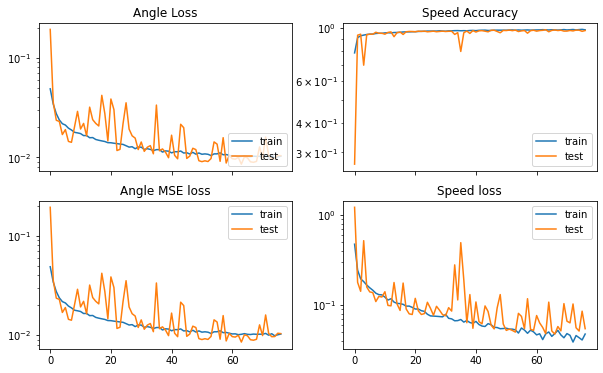

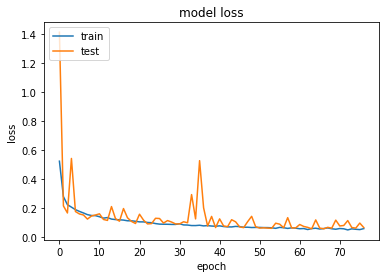

In [20]:
plots(history)

# Evaluation using validation set

In [21]:
def validation_generator(df, batch_size, target_size):
    while True:

        for i in range(0, len(df), batch_size):
            batch = df
            # Load images and labels
            images = []
            for _, row in batch.iterrows():
                img = cv2.imread(row['images'])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, target_size)
                images.append(img)

            images = np.array(images) / 255.0

            yield images

In [22]:
from keras.models import load_model
model = load_model('model/Nvidia_CNN2')
valgen = next(validation_generator(X_valid, batch_size=2759, target_size=(240, 180)))
predict = model.predict(valgen)
print(predict)

87/87 [==============================] - 3s 29ms/step
(array([[0.76387966],
       [0.40773594],
       [0.6591482 ],
       ...,
       [0.60701615],
       [0.51591915],
       [0.7057733 ]], dtype=float32), array([[2.8043549e-04],
       [9.9999923e-01],
       [9.9998379e-01],
       ...,
       [2.4008096e-04],
       [7.5473316e-04],
       [9.9999988e-01]], dtype=float32))


In [23]:
angles = pd.DataFrame(predict[0], columns=['angle'])
speed = pd.DataFrame(predict[1], columns=['speed'])
pred_df = pd.concat([angles, speed],axis=1)
pred_df.insert(0,"image_id", np.arange(1,len(pred_df)+1))

pred_df.head()

,image_id,angle,speed
0,1,0.763880,0.000280
1,2,0.407736,0.999999
2,3,0.659148,0.999984
3,4,0.645012,0.999913
4,5,0.608155,0.997361


In [24]:
pred_df.shape

(2759, 3)

### MSE before round

In [25]:
mse = tf.keras.losses.MeanSquaredError()
angle_mse = mse(X_valid['angle'], pred_df['angle']).numpy()
speed_mse = mse(X_valid['speed'], pred_df['speed']).numpy()
print(f'mse angle: {angle_mse}\nmse speed: {speed_mse}')

mse angle: 0.010239618830382824
mse speed: 0.008909819647669792


In [26]:
total_mse = angle_mse + speed_mse
print(f'Total mse: {total_mse}')

Total mse: 0.01914943754673004


In [27]:
pred_df_rnd = pred_df.round({'angle': 4,'speed': 0})
pred_df_rnd.head()

,image_id,angle,speed
0,1,0.7639,0.0
1,2,0.4077,1.0
2,3,0.6591,1.0
3,4,0.6450,1.0
4,5,0.6082,1.0


In [28]:
angle_mse = mse(X_valid['angle'], pred_df_rnd['angle']).numpy()
speed_mse = mse(X_valid['speed'], pred_df_rnd['speed']).numpy()
print(f'mse angle: {angle_mse}\nmse speed: {speed_mse}')

mse angle: 0.010239575058221817
mse speed: 0.012323305942118168


In [29]:
total_mse = angle_mse + speed_mse
print(f'Total mse: {total_mse}')

Total mse: 0.02256288006901741


In [30]:
pred_df_rnd['speed'] = pd.to_numeric(pred_df_rnd['speed'],downcast="integer" )
pred_df_rnd.head()

,image_id,angle,speed
0,1,0.7639,0
1,2,0.4077,1
2,3,0.6591,1
3,4,0.6450,1
4,5,0.6082,1


In [31]:
X_valid['speed']=X_valid['speed'].astype("int")
X_valid.head()

,angle,speed,images
12156,0.8125,0,../datasets/PiCar/train/training_data/12162.png
10399,0.4375,1,../datasets/PiCar/train/training_data/10405.png
2737,0.8125,1,../datasets/PiCar/train/training_data/2738.png
12949,0.6875,1,../datasets/PiCar/train/training_data/12955.png
3040,0.6250,1,../datasets/PiCar/train/training_data/3041.png


In [32]:
cm = confusion_matrix(X_valid['speed'], pred_df_rnd['speed'])

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       652
           1       0.99      0.99      0.99      2107

    accuracy                           0.99      2759
   macro avg       0.98      0.98      0.98      2759
weighted avg       0.99      0.99      0.99      2759



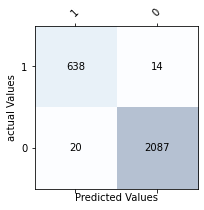

In [33]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(3,3))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i, s=cm[i,j], va='center', ha='center')
classes=["1", "0"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.xlabel('Predicted Values',)
plt.ylabel('actual Values',);
print(classification_report(X_valid['speed'], pred_df_rnd['speed']))

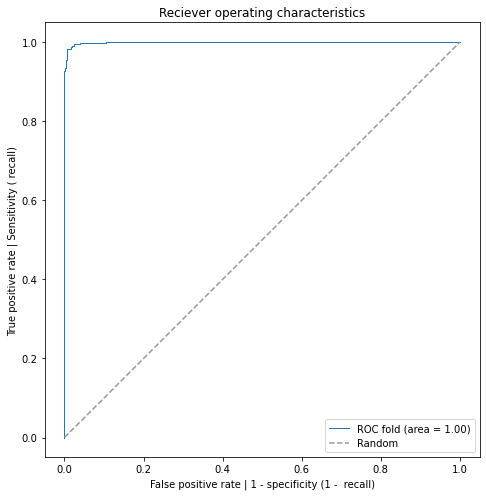

In [34]:
# Plot the rciever opertaing characteristic curve (ROC)
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10,8))
#probas_ = model.predict(X_valid['speed'])
fpr, tpr, thresholds = roc_curve(X_valid['speed'], pred_df['speed'])
roc_auc = auc(fpr,tpr)
plt.plot(fpr,tpr, lw=1, label='ROC fold (area = %0.2f)' %(roc_auc))
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])
plt.xlabel('False positive rate | 1 - specificity (1 -  recall)')
plt.ylabel('True positive rate | Sensitivity ( recall)')
plt.title('Reciever operating characteristics')
plt.legend(loc="lower right")
plt.axes().set_aspect(1);

# Testing

In [19]:
images_dir = '../datasets/PiCar/test'
file_list = os.listdir(images_dir)
image_paths = []
pattern = "*.png"

for filename in file_list:
    if fnmatch.fnmatch(filename, pattern):
        image_paths.append(os.path.join(images_dir,filename))

image_paths = natsorted(image_paths)

images = pd.DataFrame (image_paths, columns = ['images'])
images.describe()

,images
count,1020
unique,1020
top,../datasets/PiCar/test\1.png
freq,1


In [20]:
def test_generator(df, batch_size, target_size):
    while True:

        for i in range(0, len(df), batch_size):
            batch = df
            # Load images and labels
            images = []
            for _, row in batch.iterrows():
                img = cv2.imread(row['images'])
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, target_size)
                images.append(img)

            images = np.array(images) / 255.0

            yield images

In [21]:
from keras.models import load_model
model = load_model('model/Nvidia_CNN')
testgen = next(test_generator(images, batch_size=1020, target_size=(240, 120)))
predict = model.predict(testgen)
print(predict)

32/32 [==============================] - 5s 8ms/step
(array([[0.57233447],
       [0.7269628 ],
       [0.24392101],
       ...,
       [0.4193011 ],
       [0.48417288],
       [0.2161816 ]], dtype=float32), array([[0.00648858],
       [1.        ],
       [0.9712993 ],
       ...,
       [0.9992417 ],
       [0.80309635],
       [0.9901134 ]], dtype=float32))


In [22]:
angles = pd.DataFrame(predict[0], columns=['Angle'])
speed = pd.DataFrame(predict[1], columns=['speed'])
pred_df = pd.concat([angles, speed],axis=1)
pred_df.insert(0,"image_id", np.arange(1,len(pred_df)+1))

pred_df.head()

,image_id,Angle,speed
0,1,0.572334,0.006489
1,2,0.726963,1.000000
2,3,0.243921,0.971299
3,4,0.231288,0.998323
4,5,0.231272,0.947584


In [23]:
pred_df = pred_df.round({'Angle': 4, 'speed': 0})
pred_df.head()

,image_id,Angle,speed
0,1,0.5723,0.0
1,2,0.7270,1.0
2,3,0.2439,1.0
3,4,0.2313,1.0
4,5,0.2313,1.0


In [24]:
pred_df.to_csv('Tow_mat4.csv', index=False)

In [35]:
test = next(custom_generator(X_valid, batch_size=10, target_size=(240, 120), is_training=False))

In [36]:
predict_test = model.predict(test[0])

1/1 [==============================] - 0s 18ms/step


In [37]:
print(predict_test[0])

[[0.5511235 ]
 [0.7568309 ]
 [0.7777829 ]
 [0.72114545]
 [0.4993554 ]
 [0.54714364]
 [0.47722927]
 [0.5665439 ]
 [0.6199493 ]
 [0.7158552 ]]


In [38]:
print(test[1])

{'output_1': array([0.625 , 0.75  , 0.6875, 0.6875, 0.5   , 0.5   , 0.5   , 0.5625,
       0.625 , 0.6875]), 'output_2': array([1., 1., 0., 0., 1., 1., 1., 0., 1., 0.])}
